# Expedia Hotel Recommendations
### Advanced Preditive Modeling - MIS 382N
Pete Davis - pmd734

Andrew Han - ah49372

Steve Sohn - ss84926

Matthew Streichler - mrs4732

Dian Zhao - zd2473

In [2]:
# install packages if you don't have them already
#!pip install xgboost
#!pip install graphviz

     |████████████████████████████████| 1.2MB 1.7MB/s eta 0:00:01


In [1]:
# import libraries

import pandas as pd
import numpy as np
import random
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score, accuracy_score
import pickle

In [ ]:
destination = pd.read_csv("destinations.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
destination = pd.read_csv("destinations.csv")

In [ ]:
destination.head()

In [ ]:
train.head()

In [ ]:
train.columns

In [ ]:
# testing to predict 'hotel_cluster'
test.head()

## Pre-processing

In [ ]:
# making the population a set
test_ids = set(test.user_id.unique())
train_ids = set(train.user_id.unique())
intersection_count = len(test_ids & train_ids)
intersection_count == len(test_ids)

In [ ]:
# determines which columns contain NaNs
nan_list = train.isna().sum().tolist()
for i in range(len(nan_list)):
    if nan_list[i] > 0:
        index = nan_list[i]  # indexes with NaNs
        print(train.columns[i])

In [ ]:
# take out all of all of rows from user_id's that have associated NaNs
newdf = train[train['orig_destination_distance'].isnull() | (train['srch_ci'].isnull()) | (train['srch_co'].isnull())]
user_id_null = newdf['user_id'].unique().tolist()

In [ ]:
# number of rows with NaNs
user_id_null = newdf['user_id'].unique().tolist()
len(user_id_null)

In [ ]:
# updating train df to only include rows with all values
train = train[~train['user_id'].isin(user_id_null)]
train.head()

## Creating Reduced Training Set (sel_train)

In [ ]:
unique_user_id = set(train.user_id.unique())

sel_user_id = random.sample(unique_user_id,10000)
sel_train = train[train.user_id.isin(sel_user_id)]

In [ ]:
sel_train = sel_train.reset_index(drop=True)
sel_train

[46.11 10.83  4.63  2.51  2.34  2.13  1.69  1.52  1.44  1.24  1.16  1.11
  1.04  0.95  0.93  0.78  0.77  0.73  0.67  0.62  0.6   0.59  0.54  0.51
  0.5   0.5   0.44  0.43  0.42  0.41  0.39  0.37  0.36  0.35  0.32  0.32
  0.3   0.3   0.28  0.27  0.26  0.25  0.24  0.23  0.22  0.21  0.21  0.2
  0.2   0.19  0.19  0.18  0.18  0.17  0.17  0.17  0.16  0.15  0.15  0.15
  0.14  0.14  0.14  0.13  0.13  0.13  0.13  0.12  0.12  0.12  0.11  0.11
  0.11  0.11  0.1   0.1   0.1   0.09  0.09  0.09  0.09  0.09  0.08  0.08
  0.08  0.07  0.07  0.07  0.07  0.07  0.07  0.07  0.06  0.06  0.06  0.06
  0.06  0.06  0.05  0.05]


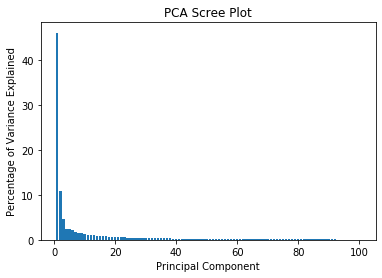

[46.11 10.83  4.63  2.51  2.34  2.13  1.69  1.52  1.44  1.24  1.16  1.11
  1.04  0.95  0.93  0.78  0.77  0.73  0.67  0.62  0.6   0.59  0.54  0.51
  0.5   0.5   0.44  0.43  0.42  0.41  0.39  0.37  0.36  0.35  0.32  0.32
  0.3   0.3   0.28  0.27  0.26  0.25  0.24  0.23  0.22  0.21  0.21  0.2
  0.2   0.19]


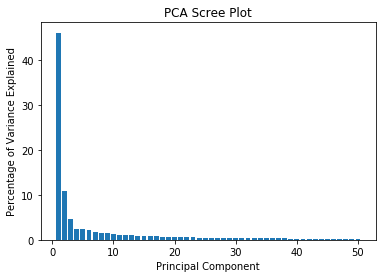

[46.11 10.83  4.63  2.51  2.34  2.13  1.69  1.52  1.44  1.24  1.16  1.11
  1.04  0.95  0.93  0.78  0.77  0.73  0.67  0.62  0.59  0.59  0.53  0.51
  0.5 ]


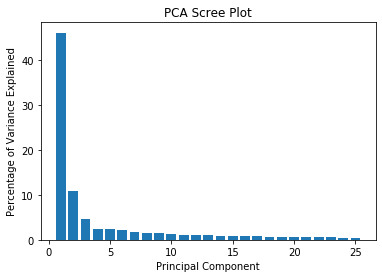

[46.11 10.83  4.63  2.51  2.34  2.13  1.69  1.52  1.44  1.24]


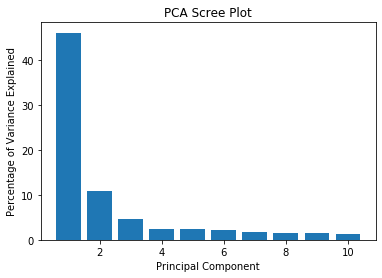

[46.11 10.83  4.63  2.51  2.34]


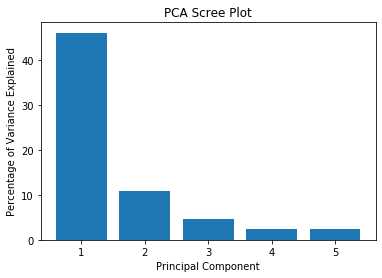

[46.11 10.83  4.63]


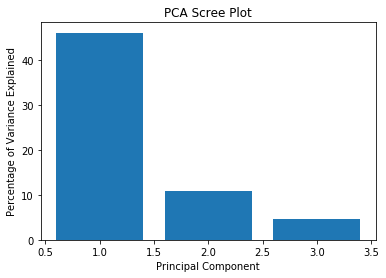

In [5]:
X = destination[["d{0}".format(i + 1) for i in range(149)]]
n_comp = [100, 50, 25, 10, 5, 3]

for n in n_comp:
    pca = PCA(n_components = n)
    pca = pca.fit(X)
    
    percent_variance = np.round(pca.explained_variance_ratio_ * 100, decimals = 2)
    print(percent_variance)
    plt.bar(x = range(1, n + 1), height = percent_variance)
    plt.ylabel('Percentage of Variance Explained')
    plt.xlabel('Principal Component')
    plt.title('PCA Scree Plot')
    plt.show()

In [ ]:
pca_ = pca.fit_transform(X)
pca_df = pd.DataFrame(pca_)
pca_df.rename(columns={0: "d_pca1", 1 : "d_pca2", 2 : "d_pca3"}, inplace = True)
pca_df

In [ ]:
pca_df["srch_destination_id"] = destination['srch_destination_id']
pca_df

In [ ]:
# merge destination df and train subset df

sel_train = sel_train.merge(pca_df, on="srch_destination_id")

In [2]:
# reading into a csv so we don't need to run above statements -- takes a lot of time
#sel_train.to_csv('sel_train.csv')

# df contains everything that we did above
# only un-comment line below if you do not want to run the above statements
sel_train = pd.read_csv("sel_train.csv")

sel_train = sel_train.drop("Unnamed: 0", axis=1)
sel_train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2013-01-08 21:57:11,2,3,66,356,4751,2644.7004,43852,0,1,...,3,1,12188,6,0,3,4,8,110,65
1,2013-01-08 22:25:36,2,3,66,356,4751,2647.2727,43852,0,1,...,3,1,12188,6,0,1,4,8,110,52
2,2014-02-16 01:21:35,2,3,66,356,4751,2644.4476,43852,0,1,...,2,1,8791,1,0,3,4,8,110,17
3,2014-02-16 01:25:35,2,3,66,356,4751,2642.0581,43852,0,1,...,2,1,8791,1,0,4,4,8,110,87
4,2014-02-16 01:41:09,2,3,66,356,4751,2642.0581,43852,0,1,...,2,1,8791,1,1,1,4,8,110,87


## Exploratory Data Analysis

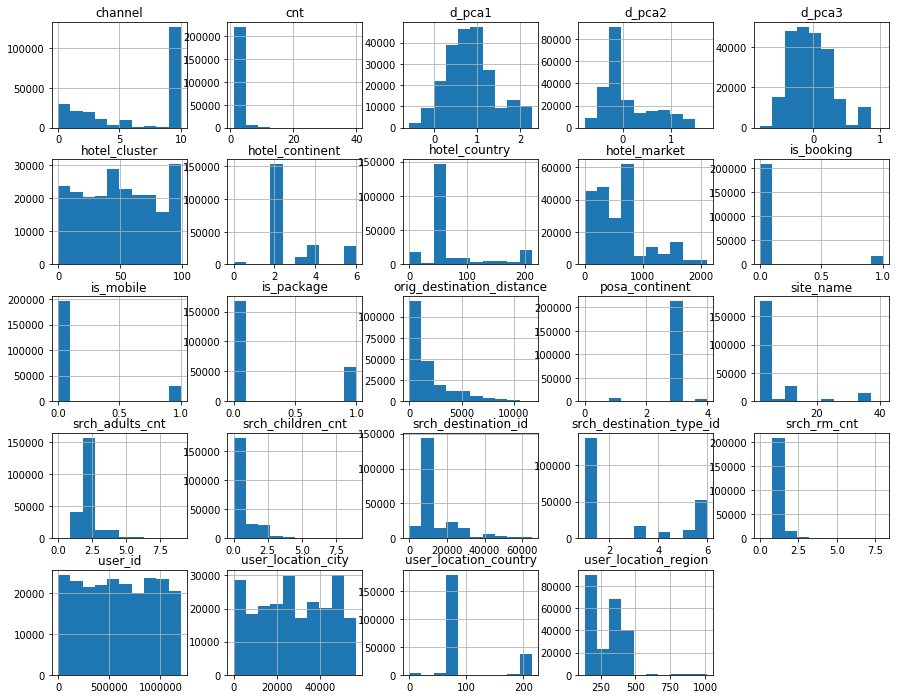

In [5]:
# histograms of each feature
sel_train.hist(figsize=(15, 12))
pyplot.show()

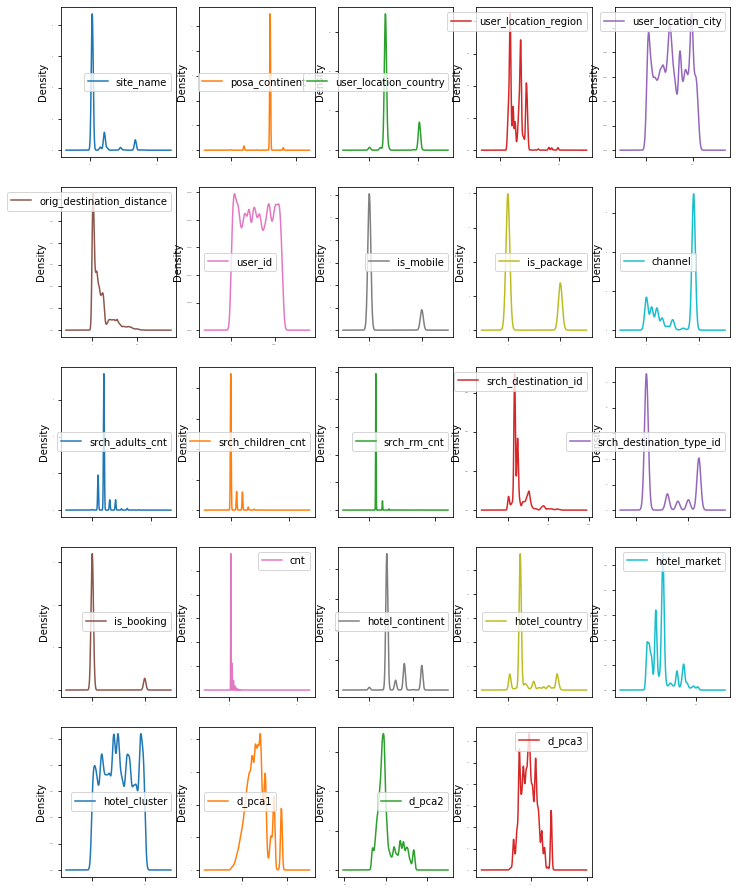

In [13]:
# density plots of each feature
sel_train.plot(kind='density', subplots=True, layout=(5, 5), sharex=False, legend=True, fontsize=1, figsize=(12, 16))
pyplot.show()

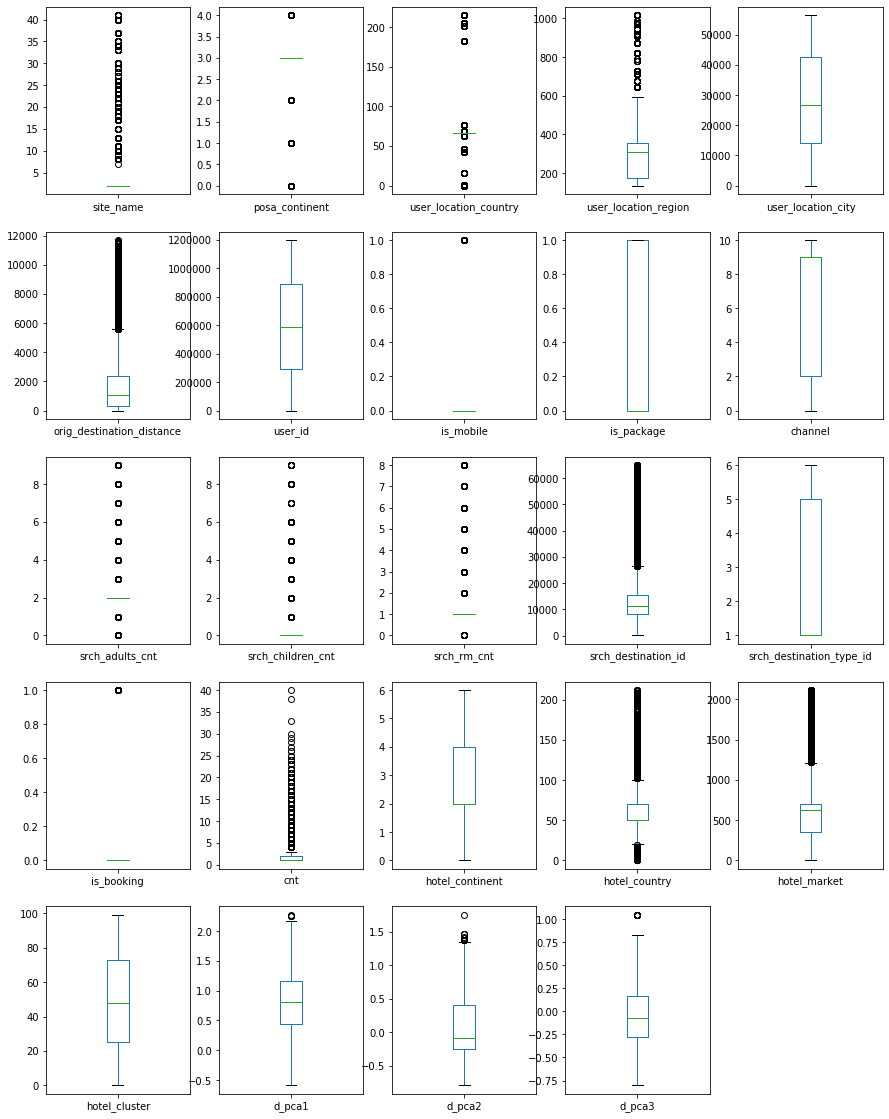

In [14]:
# box plots of each feature
sel_train.plot(kind='box', subplots=True, layout=(5,5), sharex=False, figsize=(15,20))
pyplot.show()

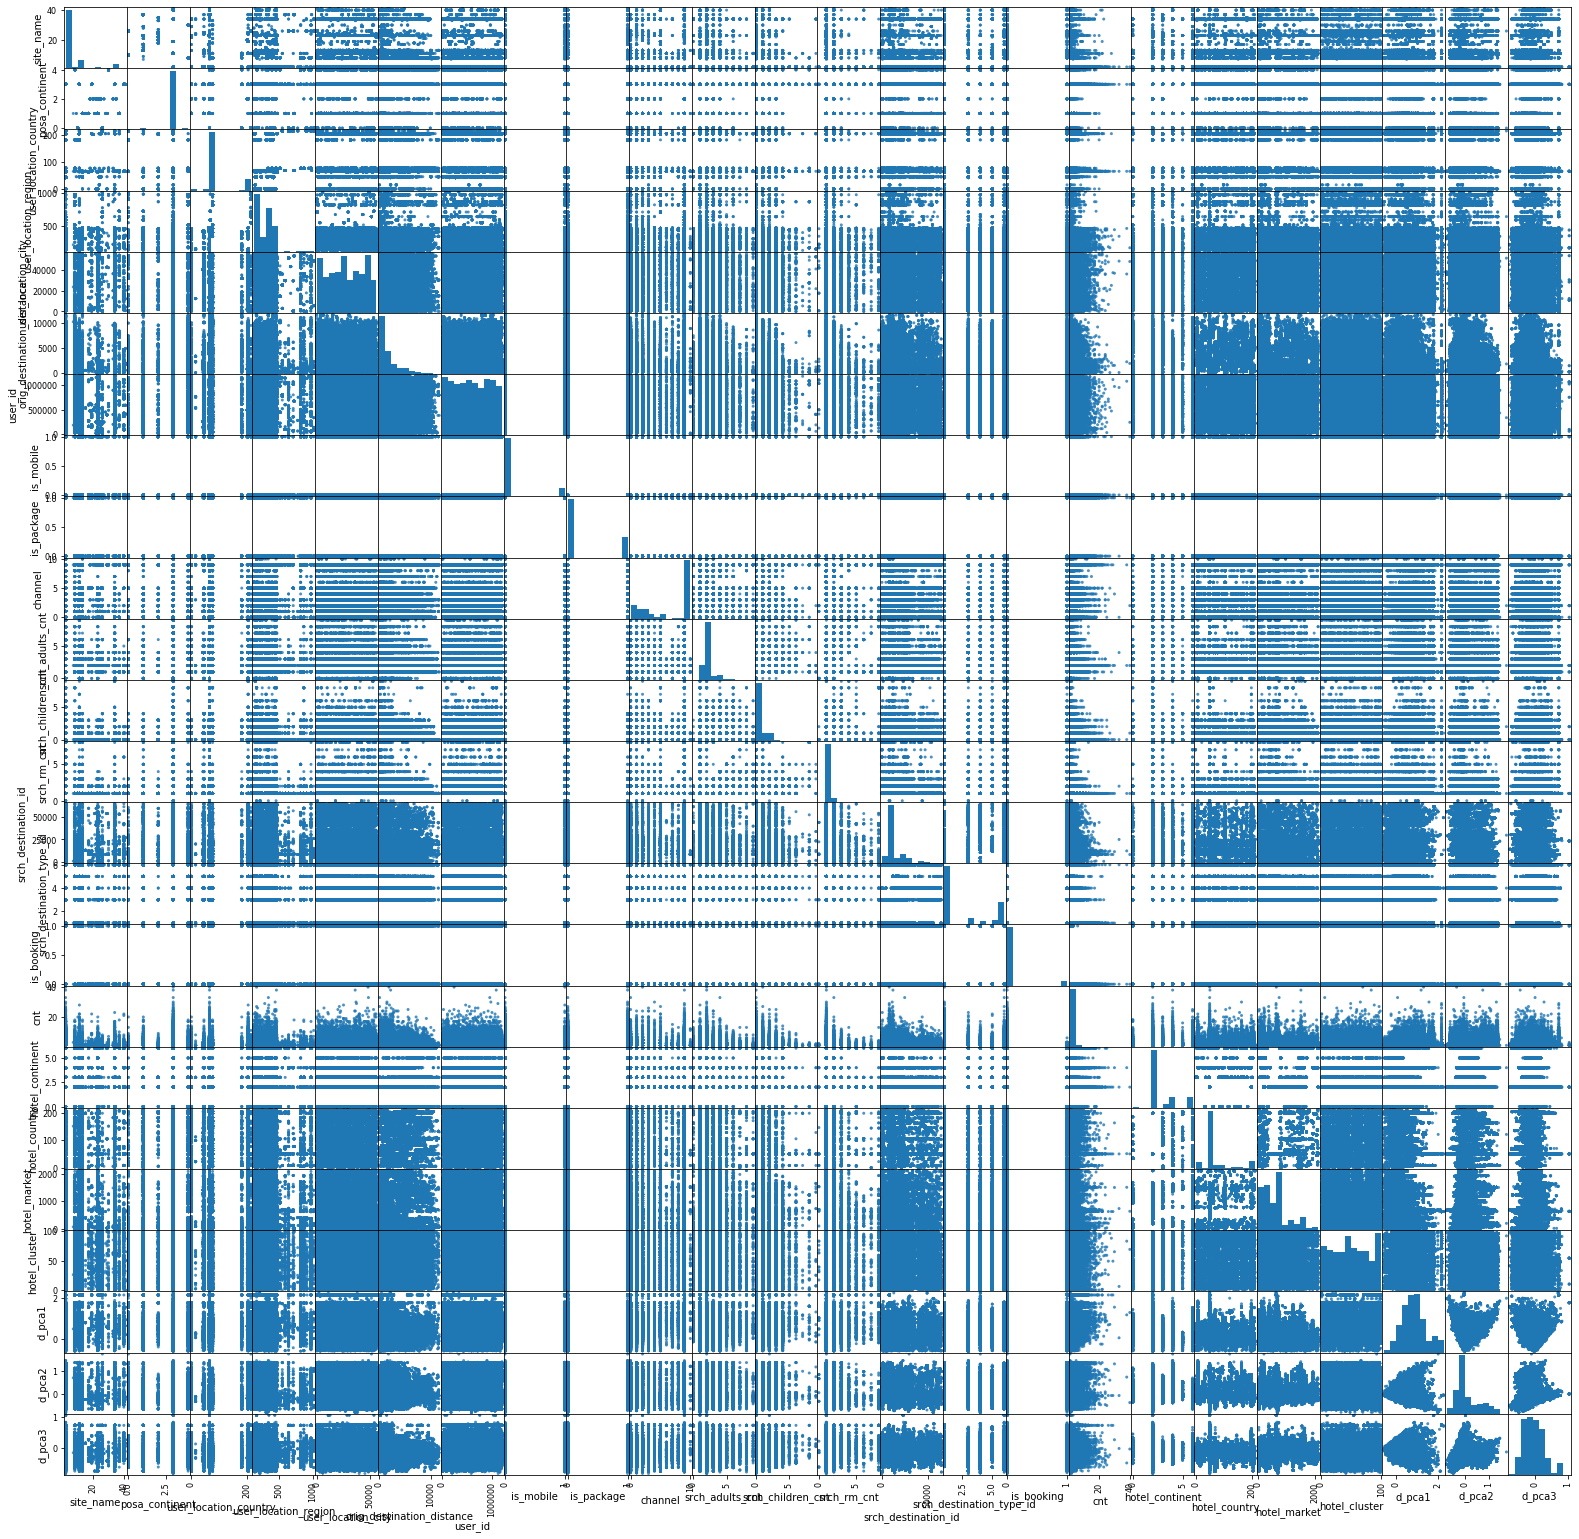

In [4]:
# scatter plot matrix between each feature
scatter_matrix(sel_train, alpha=0.8, figsize=(27, 27))
pyplot.show()

In [25]:
top_20_clusters = sel_train.hotel_cluster.value_counts().sort_values(ascending = False)[:20]
top_20_clusters

91    8563
48    5848
65    5433
41    5178
18    4272
42    4139
50    3749
28    3668
95    3668
21    3631
83    3630
70    3594
72    3576
1     3572
98    3532
47    3259
16    3243
37    3220
68    3113
59    3071
Name: hotel_cluster, dtype: int64

In [26]:
sel_train.corr()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,hotel_cluster,d_pca1,d_pca2,d_pca3,year,month,co_year,co_month,ci_year,ci_month
site_name,1.000000,-0.265932,0.644376,-0.030228,0.049124,0.030307,-0.017079,0.002768,0.020870,0.106556,...,-0.015671,-0.014873,-0.075477,0.008696,-0.080994,-0.015634,-0.054483,-0.010561,-0.058176,-0.008332
posa_continent,-0.265932,1.000000,0.116060,0.110853,0.012413,0.033552,0.028450,0.001512,-0.072639,0.026708,...,0.003783,0.060273,0.054819,0.081241,0.004758,-0.006156,-0.002027,0.006761,0.008776,-0.012762
user_location_country,0.644376,0.116060,1.000000,-0.076338,0.079754,0.057606,-0.012910,-0.010517,-0.011933,0.065503,...,-0.018993,0.044922,-0.050851,0.065004,-0.064328,-0.009469,-0.036855,-0.004685,-0.033630,-0.013479
user_location_region,-0.030228,0.110853,-0.076338,1.000000,0.129987,0.063206,-0.001978,-0.008453,0.008164,-0.020699,...,0.008287,-0.060254,-0.010728,-0.065312,0.009235,-0.007488,0.022119,-0.012561,0.022482,-0.013792
user_location_city,0.049124,0.012413,0.079754,0.129987,1.000000,0.000362,-0.016464,-0.016041,0.002944,0.010099,...,-0.000479,-0.011896,-0.007932,-0.017414,0.002643,-0.002316,-0.000110,0.004767,0.001057,0.001909
orig_destination_distance,0.030307,0.033552,0.057606,0.063206,0.000362,1.000000,-0.007719,-0.046558,0.079768,0.009455,...,0.005330,-0.201391,0.018132,-0.215528,0.017639,-0.003734,0.126564,-0.050344,0.122448,-0.040652
user_id,-0.017079,0.028450,-0.012910,-0.001978,-0.016464,-0.007719,1.000000,0.034096,-0.003270,-0.010031,...,0.000430,0.003792,0.014046,0.015150,-0.004355,0.006310,0.002846,-0.005221,0.001265,-0.000886
is_mobile,0.002768,0.001512,-0.010517,-0.008453,-0.016041,-0.046558,0.034096,1.000000,0.029879,-0.059895,...,0.005226,0.020985,0.039770,0.013509,0.040048,0.024633,0.041338,-0.004939,0.039380,0.000962
is_package,0.020870,-0.072639,-0.011933,0.008164,0.002944,0.079768,-0.003270,0.029879,1.000000,-0.001401,...,0.047849,0.229262,0.316404,0.024901,-0.009896,-0.014676,0.080558,-0.057340,0.075348,-0.050693
channel,0.106556,0.026708,0.065503,-0.020699,0.010099,0.009455,-0.010031,-0.059895,-0.001401,1.000000,...,-0.002459,0.013244,-0.040464,0.025364,-0.057297,-0.026072,-0.063898,0.000292,-0.062188,-0.006766


In [27]:
sel_train.describe()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,hotel_cluster,d_pca1,d_pca2,d_pca3,year,month,co_year,co_month,ci_year,ci_month
count,225490.000000,225490.000000,225490.000000,225490.000000,225490.000000,225490.000000,2.254900e+05,225490.000000,225490.000000,225490.000000,...,225490.000000,225490.000000,225490.000000,225490.000000,225490.00000,225490.000000,225490.000000,225490.000000,225490.000000,225490.000000
mean,5.613517,2.947093,88.044308,295.424334,27757.296607,1812.130305,5.910585e+05,0.130032,0.257009,5.834569,...,49.735332,0.844511,0.087822,-0.043276,2013.73127,7.191028,2013.900452,7.016440,2013.877977,7.170384
std,8.449891,0.403755,53.081275,129.155993,16465.507110,2091.197852,3.458070e+05,0.336340,0.436985,3.772678,...,29.118668,0.563310,0.507947,0.307031,0.44330,3.251224,0.599292,3.382595,0.583556,3.347550
min,2.000000,0.000000,0.000000,135.000000,0.000000,0.005600,5.000000e+00,0.000000,0.000000,0.000000,...,0.000000,-0.588956,-0.793420,-0.802575,2013.00000,1.000000,2013.000000,1.000000,2013.000000,1.000000
25%,2.000000,3.000000,66.000000,174.000000,14052.000000,284.513925,2.914460e+05,0.000000,0.000000,2.000000,...,25.000000,0.448790,-0.246364,-0.273277,2013.00000,5.000000,2014.000000,4.000000,2014.000000,5.000000
50%,2.000000,3.000000,66.000000,311.000000,26644.000000,1068.544800,5.856080e+05,0.000000,0.000000,9.000000,...,48.000000,0.808111,-0.085886,-0.068206,2014.00000,7.000000,2014.000000,7.000000,2014.000000,7.000000
75%,2.000000,3.000000,66.000000,354.000000,42500.000000,2404.172100,8.920370e+05,0.000000,1.000000,9.000000,...,73.000000,1.156146,0.401561,0.166331,2014.00000,10.000000,2014.000000,10.000000,2014.000000,10.000000
max,41.000000,4.000000,215.000000,1017.000000,56488.000000,11692.632000,1.198746e+06,1.000000,1.000000,10.000000,...,99.000000,2.270603,1.752461,1.045861,2014.00000,12.000000,2016.000000,12.000000,2016.000000,12.000000


In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13357 entries, 214204 to 208711
Data columns (total 29 columns):
site_name                    13357 non-null int64
posa_continent               13357 non-null int64
user_location_country        13357 non-null int64
user_location_region         13357 non-null int64
user_location_city           13357 non-null int64
orig_destination_distance    13357 non-null float64
user_id                      13357 non-null int64
is_mobile                    13357 non-null int64
is_package                   13357 non-null int64
channel                      13357 non-null int64
srch_adults_cnt              13357 non-null int64
srch_children_cnt            13357 non-null int64
srch_rm_cnt                  13357 non-null int64
srch_destination_id          13357 non-null int64
srch_destination_type_id     13357 non-null int64
is_booking                   13357 non-null int64
cnt                          13357 non-null int64
hotel_continent              1335

In [89]:
# Date Time Conversion 
sel_train["date_time"] = pd.to_datetime(sel_train["date_time"])
sel_train["year"] = sel_train["date_time"].dt.year
sel_train["month"] = sel_train["date_time"].dt.month


sel_train['srch_ci'] = pd.to_datetime(sel_train['srch_ci'])
sel_train["ci_year"] = sel_train["srch_ci"].dt.year
sel_train["ci_month"] = sel_train["srch_ci"].dt.month


sel_train['srch_co'] = pd.to_datetime(sel_train['srch_co'])
sel_train["co_year"] = sel_train["srch_co"].dt.year
sel_train["co_month"] = sel_train["srch_co"].dt.month

sel_train = sel_train.drop(["date_time", "srch_co", 'srch_ci'], axis = 1)
sel_train

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,ci_year,ci_month,co_year,co_month
0,2,3,66,356,4751,2644.7004,43852,0,1,1,...,4,8,110,65,2013,1,2013,4,2013,5
1,2,3,66,356,4751,2647.2727,43852,0,1,1,...,4,8,110,52,2013,1,2013,4,2013,5
2,2,3,66,356,4751,2644.4476,43852,0,1,3,...,4,8,110,17,2014,2,2014,2,2014,3
3,2,3,66,356,4751,2642.0581,43852,0,1,3,...,4,8,110,87,2014,2,2014,2,2014,3
4,2,3,66,356,4751,2642.0581,43852,0,1,3,...,4,8,110,87,2014,2,2014,2,2014,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225050,11,3,205,155,14703,5353.0124,1155187,0,0,0,...,6,77,2,64,2014,8,2014,12,2014,12
225051,11,3,205,155,14703,5354.3080,1155187,0,0,0,...,6,204,1466,64,2014,8,2014,12,2015,1
225052,11,3,205,155,14703,2712.1331,1155187,0,0,9,...,2,50,212,33,2014,9,2014,12,2014,12
225053,11,3,205,155,14703,2712.1764,1155187,0,0,9,...,2,50,212,20,2014,9,2014,12,2014,12


## Train and Test Split

In [90]:
y = sel_train["hotel_cluster"]
X = sel_train.drop("hotel_cluster", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [95]:
# change type of categorial number variables to category
X[['site_name', 'posa_continent', 'user_location_country', 
   'user_location_region', 'user_location_city', 'user_id', 
   'channel', 'hotel_continent', 'hotel_country', 'hotel_market', 
   'year', 'month', 'ci_year', 'ci_month', 'co_year', 'co_month']] = X[['site_name', 'posa_continent', 
                                                                        'user_location_country', 'user_location_region', 
                                                                        'user_location_city', 'user_id', 'channel', 
                                                                        'hotel_continent', 'hotel_country', 
                                                                        'hotel_market', 'year', 'month', 
                                                                        'ci_year', 'ci_month', 'co_year', 
                                                                        'co_month']].astype('category')
variables = pd.DataFrame(X.dtypes)
variables = variables.reset_index().rename(columns= {'index':'Variable', 0:'Type'}).set_index('Variable')
variables

,Type
Variable,
site_name,category
posa_continent,category
user_location_country,category
user_location_region,category
user_location_city,category
orig_destination_distance,float64
user_id,category
is_mobile,int64
is_package,int64


In [61]:
variables = pd.DataFrame(X.dtypes)
variables = variables.reset_index().rename(columns= {'index':'Variable', 0:'Type'}).set_index('Variable')
variables

#[['Variable', 'Type']].groupby(['Variable']).agg('count')

,Type
Variable,
date_time,object
site_name,category
posa_continent,category
user_location_country,category
user_location_region,category
user_location_city,category
orig_destination_distance,float64
user_id,category
is_mobile,int64


### Default Model

In [96]:
#Find the most frequent cluster in the training set
y_df = y_train.to_frame()
most_frequent_cluster = y_df['hotel_cluster'].value_counts().idxmax()
print('The most frequent hotel cluster is: ' + str(most_frequent_cluster))
y_df['hotel_cluster'] = most_frequent_cluster
y_most_frequent = y_df['hotel_cluster']

The most frequent hotel cluster is: 91


In [8]:
from sklearn.metrics import accuracy_score

#set the y_test and y_train to the most frequent cluster
most_frequent_train = y_most_frequent
most_frequent_test = y_most_frequent[:len(y_test)]

print('The most frequent hotel cluster is: ' + str(most_frequent_cluster))
print()
print("Train Accuracy:", (accuracy_score(y_train, most_frequent_train)))
print("Test Accuracy:", (accuracy_score(y_test, most_frequent_test)))
print()

The most frequent hotel cluster is: 91

Train Accuracy: 0.03636449810712657
Test Accuracy: 0.036968576709796676



#### Logistics Multi-class

In [11]:
### To see if performance improves with less number of features
### First trying only 3 PCAs

X_sel_3PCA = sel_train[['d_pca1','d_pca2','d_pca3']]
X_sel_3PCA_train, X_sel_3PCA_test, y_train, y_test = train_test_split(X_sel_3PCA, y, test_size = 0.25, random_state = 42)

### One-hot table from y
y_train_onehot = pd.get_dummies(y_train, prefix='Cluster')
y_test_onehot  = pd.get_dummies(y_test, prefix='Cluster')
#print(y_onehot.describe())

### Verify column name and cluster match
#mask = [y_test == '28']
y_test2 = y_test.reset_index()
print(y_test2['hotel_cluster'].value_counts(ascending=False))
print(y_test_onehot.sum().sort_values(ascending=False))

91    2162
48    1512
65    1353
41    1331
18    1090
      ... 
12     165
35     133
53     118
74      98
27      97
Name: hotel_cluster, Length: 100, dtype: int64
Cluster_91    2162
Cluster_48    1512
Cluster_65    1353
Cluster_41    1331
Cluster_18    1090
              ... 
Cluster_12     165
Cluster_35     133
Cluster_53     118
Cluster_74      98
Cluster_27      97
Length: 100, dtype: int64


In [12]:
# we are splitting our training data set into a subset of training and testing sets 
y = sel_train["hotel_cluster"]
X = sel_train.drop("hotel_cluster", axis = 1)

### 
#   Xc: types are converted to datetime, categories -> used for HGBoost
#   X2: types are converted to integers -> used for regression


## convert date_time, srch_ci, srch_co into integers for XGBoost
X2 = X
X2['date_time'] = X2['date_time'].apply(lambda x: x.replace('-', '')[:8]).astype('int32')
X2['srch_ci'] = X2['srch_ci'].apply(lambda x: x.replace('-', '')).astype('int32')
X2['srch_co'] = X2['srch_co'].apply(lambda x: x.replace('-', '')).astype('int32')

X_sel_train, X_sel_test, y_train, y_test = train_test_split(X2, y, test_size = 0.25, random_state = 42)

## Add a new column for length of stay, convert to integer
X2['len_stay'] = X2['srch_co'] - X2["srch_ci"]
#Xc['len_stay'] = Xc['len_stay'].astype('object').apply(lambda x: x.replace('-', '')[:8]).astype('int32')
#X2['len_stay'] = X2['len_stay'].astype('object').apply(lambda x: x.days).astype('int32')


### X_train with 11 features -> first used channel, but switched to len_stay
X_sel_11 = X2[["orig_destination_distance", 'is_mobile','srch_adults_cnt','srch_children_cnt','srch_rm_cnt','is_booking','cnt','d_pca1','d_pca2','d_pca3','len_stay']]
X_sel_11_train, X_sel_11_test, y_train, y_test = train_test_split(X_sel_11, y, test_size = 0.25, random_state = 42)

### X_train with 5 features
X_sel_5 = X2[["orig_destination_distance",'is_booking','d_pca1','d_pca2','d_pca3']]
X_sel_5_train, X_sel_5_test, y_train, y_test = train_test_split(X_sel_5, y, test_size = 0.25, random_state = 42)

### X_train with 3 PCA features
X_sel_3 = X2[['d_pca1','d_pca2','d_pca3']]
X_sel_3_train, X_sel_3_test, y_train, y_test = train_test_split(X_sel_3, y, test_size = 0.25, random_state = 42)


### Trying categoies for Logistic Regression - (this did not work for HGBoost)
### Change some columns as category
### site_name, posa_continent, user_location_country, user_location_region, user_location_city, user_id, channel, hotel_continent, hotel_country, hotel_market
Xc = X
Xc[['site_name', 'posa_continent', 'user_location_country', 'user_location_region', 'user_location_city', 'user_id', 'channel', 'hotel_continent', 'hotel_country', 'hotel_market']] = Xc[['site_name', 'posa_continent', 'user_location_country', 'user_location_region', 'user_location_city', 'user_id', 'channel', 'hotel_continent', 'hotel_country', 'hotel_market']].astype('category')

# 1) from srch_ci and srch_co -> create a new column for length of stay
Xc["date_time"] = pd.to_datetime(Xc["date_time"], format='%Y-%m-%d', errors="coerce")
Xc["srch_ci"] = pd.to_datetime(Xc["srch_ci"], format='%Y-%m-%d', errors="coerce")
Xc["srch_co"] = pd.to_datetime(Xc["srch_co"], format='%Y-%m-%d', errors="coerce")


# 2) 
Xc_train, Xc_test, y_train, y_test = train_test_split(Xc, y, test_size = 0.25, random_state = 42)

### Logistic Regression - choosing from Xc (some types converted to category) with 12 features
Xc_sel_12 = Xc[["orig_destination_distance", 'is_mobile','channel','srch_adults_cnt','srch_children_cnt','srch_rm_cnt','is_booking','cnt','d_pca1','d_pca2','d_pca3','len_stay']]
Xc_sel_12_train, Xc_sel_12_test, y_train, y_test = train_test_split(Xc_sel_12, y, test_size = 0.25, random_state = 42)


Xc.dtypes

date_time                    datetime64[ns]
site_name                          category
posa_continent                     category
user_location_country              category
user_location_region               category
user_location_city                 category
orig_destination_distance           float64
user_id                            category
is_mobile                             int64
is_package                            int64
channel                            category
srch_ci                      datetime64[ns]
srch_co                      datetime64[ns]
srch_adults_cnt                       int64
srch_children_cnt                     int64
srch_rm_cnt                           int64
srch_destination_id                   int64
srch_destination_type_id              int64
is_booking                            int64
cnt                                   int64
hotel_continent                    category
hotel_country                      category
hotel_market                    

In [13]:
X_sel_11.dtypes

orig_destination_distance    float64
is_mobile                      int64
srch_adults_cnt                int64
srch_children_cnt              int64
srch_rm_cnt                    int64
is_booking                     int64
cnt                            int64
d_pca1                       float64
d_pca2                       float64
d_pca3                       float64
len_stay                       int32
dtype: object

In [14]:
### X with 12 features (categorical - using Xc)

#penalties         = ['l1', 'l2', 'elasticnet', 'none']
c_regularization  = [0.0001,0.001,0.1,1,10,100]   
LR_multi_12_fit_save  = []
LR_multi_12_condition = []
LR_multi_12_score_train_save = []
LR_multi_12_score_test_save = []

for regularization_i in c_regularization:

    LR_multi_12       = LogisticRegression(penalty='l2', C=regularization_i, max_iter=2000, multi_class='ovr', random_state=42)
    LR_multi_12_fit   = LR_multi_12.fit(Xc_sel_12_train, y_train)
    LR_multi_12_pred_train  = LR_multi_12_fit.predict(Xc_sel_12_train)
    LR_multi_12_pred_test   = LR_multi_12_fit.predict(Xc_sel_12_test)
    LR_multi_12_score_train = accuracy_score(y_train, LR_multi_12_pred_train)
    LR_multi_12_score_test  = accuracy_score(y_test, LR_multi_12_pred_test)

    LR_multi_12_fit_save.append(LR_multi_12_fit)
    LR_multi_12_condition.append(regularization_i)
    LR_multi_12_score_train_save.append(LR_multi_12_score_train)
    LR_multi_12_score_test_save.append(LR_multi_12_score_test)
    print("Regularization:",regularization_i, "Train Accuracy:", LR_multi_12_score_train)
    print("Regularization:",regularization_i, "Test Accuracy :", LR_multi_12_score_test)

print("Highest Test Accuracy achieved is:", max(LR_multi_12_score_test_save))  

# save the model to disk
# import pickle
# pickle.dump(LR_multi_12_fit_save, open('LR_multi_12_fit_save.pkl','wb'))        

Regularization: 0.0001 Train Accuracy: 0.06324615502876707
Regularization: 0.0001 Test Accuracy : 0.06391357564791655
Regularization: 0.001 Train Accuracy: 0.08541423984578723
Regularization: 0.001 Test Accuracy : 0.08688556578503893


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Regularization: 0.1 Train Accuracy: 0.09891968282313428
Regularization: 0.1 Test Accuracy : 0.09759991485285509


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Regularization: 1 Train Accuracy: 0.09936316278079672
Regularization: 1 Test Accuracy : 0.09804338956592695
Regularization: 10 Train Accuracy: 0.09922716226044691
Regularization: 10 Test Accuracy : 0.09816756248558707
Regularization: 100 Train Accuracy: 0.09969429448251801
Regularization: 100 Test Accuracy : 0.09875294910684193
Highest Test Accuracy achieved is: 0.09875294910684193


In [15]:
### X with 11 features

#penalties         = ['l1', 'l2', 'elasticnet', 'none']
c_regularization  = [0.0001,0.001,0.1,1,10,100]   
LR_multi_11_fit_save  = []
LR_multi_11_condition = []
LR_multi_11_score_train_save = []
LR_multi_11_score_test_save = []

for regularization_i in c_regularization:

    LR_multi_11       = LogisticRegression(penalty='l2', C=regularization_i, max_iter=1000, multi_class='ovr', random_state=42)
    LR_multi_11_fit   = LR_multi_11.fit(X_sel_11_train, y_train)
    LR_multi_11_pred_train  = LR_multi_11_fit.predict(X_sel_11_train)
    LR_multi_11_pred_test   = LR_multi_11_fit.predict(X_sel_11_test)
    LR_multi_11_score_train = accuracy_score(y_train, LR_multi_11_pred_train)
    LR_multi_11_score_test  = accuracy_score(y_test, LR_multi_11_pred_test)

    LR_multi_11_fit_save.append(LR_multi_11_fit)
    LR_multi_11_condition.append(regularization_i)
    LR_multi_11_score_train_save.append(LR_multi_11_score_train)
    LR_multi_11_score_test_save.append(LR_multi_11_score_test)
    print("Regularization:",regularization_i, "Train Accuracy:", LR_multi_11_score_train)
    print("Regularization:",regularization_i, "Test Accuracy :", LR_multi_11_score_test)

print("Highest Test Accuracy achieved is:", max(LR_multi_11_score_test_save))  

# save the model to disk
# import pickle
# pickle.dump(LR_multi_11_fit_save, open('LR_multi_11_fit_save.pkl','wb'))        

Regularization: 0.0001 Train Accuracy: 0.06339398168132121
Regularization: 0.0001 Test Accuracy : 0.06439252833803416
Regularization: 0.001 Train Accuracy: 0.0851599780033941
Regularization: 0.001 Test Accuracy : 0.08615826725560109


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

Regularization: 0.1 Train Accuracy: 0.09731724190944731
Regularization: 0.1 Test Accuracy : 0.09678392138080287
Regularization: 1 Train Accuracy: 0.09613462868901411
Regularization: 1 Test Accuracy : 0.0951696734252213


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Regularization: 10 Train Accuracy: 0.09650715185345057
Regularization: 10 Test Accuracy : 0.09561314813829315


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Regularization: 100 Train Accuracy: 0.09729950271114081
Regularization: 100 Test Accuracy : 0.09701452823160023
Highest Test Accuracy achieved is: 0.09701452823160023


In [16]:
# #open pickl file and load
# LR_multi_11_fit_temp = open('LR_multi_11_fit_save.pkl', 'rb') 
# LR_multi_11_fit_save = pickle.load(LR_multi_1_fit_temp)
# LR_multi_11_fit_save

In [17]:
### X with 5 features

penalties         = ['l2', 'none']
c_regularization  = [0.0001,0.001,0.1,1,10,100]  
LR_multi_5_fit_save  = []
LR_multi_5_condition = []
LR_multi_5_score_train_save = []
LR_multi_5_score_test_save = []


for regularization_i in c_regularization:

    LR_multi_5       = LogisticRegression(penalty='l2', C=regularization_i, max_iter=1000, multi_class='ovr', random_state=42)
    LR_multi_5_fit   = LR_multi_5.fit(X_sel_5_train, y_train)
    LR_multi_5_pred_train  = LR_multi_5_fit.predict(X_sel_5_train)
    LR_multi_5_pred_test   = LR_multi_5_fit.predict(X_sel_5_test)
    LR_multi_5_score_train = accuracy_score(y_train, LR_multi_5_pred_train)
    LR_multi_5_score_test  = accuracy_score(y_test, LR_multi_5_pred_test)

    LR_multi_5_fit_save.append(LR_multi_5_fit)
    LR_multi_5_condition.append(regularization_i)
    LR_multi_5_score_train_save.append(LR_multi_5_score_train)
    LR_multi_5_score_test_save.append(LR_multi_5_score_test)
    print("Regularization:",regularization_i, "Train Accuracy:", LR_multi_5_score_train)
    print("Regularization:",regularization_i, "Test Accuracy :", LR_multi_5_score_test)

        
print("Highest Test Accuracy achieved is:", max(LR_multi_5_score_test_save))        
# save the model to disk
# import pickle
# pickle.dump(LR_multi_5_fit_save, open('LR_multi_5_fit_save.pkl','wb'))        

Regularization: 0.0001 Train Accuracy: 0.06293276252535226
Regularization: 0.0001 Test Accuracy : 0.06371844677416494
Regularization: 0.001 Train Accuracy: 0.0840305823778804
Regularization: 0.001 Test Accuracy : 0.08509392794422863
Regularization: 0.1 Train Accuracy: 0.09533045169911955
Regularization: 0.1 Test Accuracy : 0.09454880882692068
Regularization: 1 Train Accuracy: 0.09591584524323397
Regularization: 1 Test Accuracy : 0.0950277615170383
Regularization: 10 Train Accuracy: 0.09573254019406682
Regularization: 10 Test Accuracy : 0.09472619871214943
Regularization: 100 Train Accuracy: 0.09601045430086863
Regularization: 100 Test Accuracy : 0.09534706331045004
Highest Test Accuracy achieved is: 0.09534706331045004


In [18]:
### X with 3 features

penalties         = ['l2', 'none']
c_regularization  = [0.0001,0.001,0.1,1,10,100]  
LR_multi_3_fit_save  = []
LR_multi_3_condition = []
LR_multi_3_score_train_save = []
LR_multi_3_score_test_save = []


for regularization_i in c_regularization:

    LR_multi_3       = LogisticRegression(penalty='l2', C=regularization_i, max_iter=1000, multi_class='ovr', random_state=42)
    LR_multi_3_fit   = LR_multi_5.fit(X_sel_3_train, y_train)
    LR_multi_3_pred_train  = LR_multi_3_fit.predict(X_sel_3_train)
    LR_multi_3_pred_test   = LR_multi_3_fit.predict(X_sel_3_test)
    LR_multi_3_score_train = accuracy_score(y_train, LR_multi_3_pred_train)
    LR_multi_3_score_test  = accuracy_score(y_test, LR_multi_3_pred_test)

    LR_multi_3_fit_save.append(LR_multi_3_fit)
    LR_multi_3_condition.append(regularization_i)
    LR_multi_3_score_train_save.append(LR_multi_3_score_train)
    LR_multi_3_score_test_save.append(LR_multi_3_score_test)
    print("Regularization:",regularization_i, "Train Accuracy:", LR_multi_3_score_train)
    print("Regularization:",regularization_i, "Test Accuracy :", LR_multi_3_score_test)

        
print("Highest Test Accuracy achieved is:", max(LR_multi_3_score_test_save))        
# save the model to disk
# import pickle
# pickle.dump(LR_multi_3_fit_save, open('LR_multi_3_fit_save.pkl','wb'))        

Regularization: 0.0001 Train Accuracy: 0.0879391190714121
Regularization: 0.0001 Test Accuracy : 0.08683234881947031
Regularization: 0.001 Train Accuracy: 0.0879391190714121
Regularization: 0.001 Test Accuracy : 0.08683234881947031
Regularization: 0.1 Train Accuracy: 0.0879391190714121
Regularization: 0.1 Test Accuracy : 0.08683234881947031
Regularization: 1 Train Accuracy: 0.0879391190714121
Regularization: 1 Test Accuracy : 0.08683234881947031
Regularization: 10 Train Accuracy: 0.0879391190714121
Regularization: 10 Test Accuracy : 0.08683234881947031
Regularization: 100 Train Accuracy: 0.0879391190714121
Regularization: 100 Test Accuracy : 0.08683234881947031
Highest Test Accuracy achieved is: 0.08683234881947031


#### XGBoost

In [ ]:
### XGBoost - X with all features

D_all_train = xgb.DMatrix(X_sel_train, label=y_train)
D_all_test  = xgb.DMatrix(X_sel_test,  label=y_test)


D_all_model_save = []

## loop through different parameters
param_learning_rate = [0.0005, 0.01, 0.05, 0.15, 0.3, 0.5]
param_max_depth     = [5, 10, 15, 20]
for learning_rate_i in param_learning_rate:
    for max_depth_i in param_max_depth:

        ## XG Boost parameters
        param = {  
            'learning_rate': learning_rate_i, 
            'max_depth': max_depth_i,  
            'objective': 'multi:softprob',  #Softprob gives probability for all clusters, softmax gives cluster with max prob..
            'num_class': 100}  # number of clusters

        steps = 20  # The number of training iterations
        
        D_all_model = xgb.train(param, D_all_train, steps)
        D_all_model_save.append(D_all_model)
        D_all_preds = D_all_model.predict(D_all_test)
        D_all_best_preds = np.asarray([np.argmax(line) for line in D_all_preds])

        print("Learning Rate =",learning_rate_i, "Max Depth =", max_depth_i)
        print(" Precision = {}".format(precision_score(y_test, D_all_best_preds, average='macro')))
        print(" Recall    = {}".format(recall_score(y_test, D_all_best_preds, average='macro')))
        print(" Accuracy  = {}".format(accuracy_score(y_test, D_all_best_preds)))
        print('-------------\n')

In [ ]:
## Save the model into a file so we don't have to keep running it. Took more than 4 hours.
# import pickle
pickle.dump(D_all_model_save, open('D_all_model_save.pkl','wb'))  

# D_all_model_save.dump_model('D_all_model_save.raw.txt')

In [ ]:
#open pickl file and load
D_all_model_save_temp = open('D_all_model_save.pkl', 'rb') 
D_all_model_save = pickle.load(D_all_model_save_temp)
D_all_model_save

In [ ]:
## Code to run from saved file

In [ ]:
### XGBoost - X with 11 features

D_11_train = xgb.DMatrix(X_sel_11_train, label=y_train)
D_11_test  = xgb.DMatrix(X_sel_11_test,  label=y_test)

D_11_model_save = []

## loop through different parameters
param_learning_rate = [0.0005, 0.01, 0.05, 0.15, 0.3, 0.5]
param_max_depth     = [5, 10, 15, 20]
for learning_rate_i in param_learning_rate:
    for max_depth_i in param_max_depth:
        
        ## XG Boost parameters
        param = {  
            'learning_rate': learning_rate_i, 
            'max_depth': max_depth_i,  
            'objective': 'multi:softprob',  
            'num_class': 100}  # number of clusters

        steps = 20  # The number of training iterations
        D_11_model = xgb.train(param, D_11_train, steps)
        D_11_model_save.append(D_11_model)        
        D_11_preds = D_11_model.predict(D_11_test)
        D_11_best_preds = np.asarray([np.argmax(line) for line in D_11_preds])

        print("Learning Rate =",learning_rate_i, "Max Depth =", max_depth_i)
        print(" Precision = {}".format(precision_score(y_test, D_11_best_preds, average='macro')))
        print(" Recall    = {}".format(recall_score(y_test, D_11_best_preds, average='macro')))
        print(" Accuracy  = {}".format(accuracy_score(y_test, D_11_best_preds)))
        print('-------------\n')

In [ ]:
## Save the model into a file so we don't have to keep running it. Took more than 4 hours.
# import pickle
pickle.dump(D_all_model_save, open('D_11_model_save.pkl','wb'))  

In [ ]:
#open pickl file and load
D_11_model_save_temp = open('D_11_model_save.pkl', 'rb') 
D_11_model_save = pickle.load(D_11_model_save_temp)
D_11_model_save

In [ ]:
## Code to run from saved file

In [ ]:
### This does not run on my computer but it runs on Colab

plt.rcParams['figure.figsize'] = [50, 30]
xgb.plot_tree(D_11_model,num_trees=0)
plt.show()

# can save image on Colab

In [ ]:
plt.rcParams['figure.figsize'] = [8, 6]
xgb.plot_importance(D_11_model)
plt.show()

In [ ]:
### GRid Search? - just doing a few iterations because it takes too long

# from sklearn.model_selection import GridSearchCV

# clf = xgb.XGBClassifier()
# parameters = {
#      "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
#      "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
#      "min_child_weight" : [ 1, 3, 5, 7 ],
#      "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
#      "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
#      }

# grid = GridSearchCV(clf,
#                     parameters, n_jobs=4,
#                     scoring="neg_log_loss",
#                     cv=3)

# grid.fit(X_train, Y_train)

In [11]:
sel_train["date_time"] = pd.to_datetime(sel_train["date_time"])
sel_train["year"] = sel_train["date_time"].dt.year
sel_train["month"] = sel_train["date_time"].dt.month

sel_train["srch_co"] = pd.to_datetime(sel_train["srch_co"])
sel_train["co_year"] = sel_train["srch_co"].dt.year
sel_train["co_month"] = sel_train["srch_co"].dt.month

sel_train["srch_ci"] = pd.to_datetime(sel_train["srch_ci"])
sel_train["ci_year"] = sel_train["srch_ci"].dt.year
sel_train["ci_month"] = sel_train["srch_ci"].dt.month

sel_train = sel_train.drop(["date_time", "srch_ci", "srch_co"], axis=1)
sel_train.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,co_year,co_month,ci_year,ci_month
0,2,3,66,356,4751,2644.7004,43852,0,1,1,...,4,8,110,65,2013,1,2013,5,2013,4
1,2,3,66,356,4751,2647.2727,43852,0,1,1,...,4,8,110,52,2013,1,2013,5,2013,4
2,2,3,66,356,4751,2644.4476,43852,0,1,3,...,4,8,110,17,2014,2,2014,3,2014,2
3,2,3,66,356,4751,2642.0581,43852,0,1,3,...,4,8,110,87,2014,2,2014,3,2014,2
4,2,3,66,356,4751,2642.0581,43852,0,1,3,...,4,8,110,87,2014,2,2014,3,2014,2


## is_booking equals 0 or 1
#### Decision Tree

In [30]:
depths = [2, 5, 10, 15, 17, 20, None]
criterion = ["gini", "entropy"]

for c in criterion:
    for d in depths:
        dtc = tree.DecisionTreeClassifier(criterion = c, max_depth = d).fit(X_train, y_train)
        y_pred_train = dtc.predict(X_train)
        y_pred_test = dtc.predict(X_test)
        
        print("Criterion: " + c)
        print("Depth: " + str(d))
        print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
        print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
        print()

Criterion: gini
Depth: 2
Train Accuracy: 0.07640864017218849
Test Accuracy: 0.07672112536143189

Criterion: gini
Depth: 5
Train Accuracy: 0.10066403732327324
Test Accuracy: 0.09880616607241055

Criterion: gini
Depth: 10
Train Accuracy: 0.14789169628127272
Test Accuracy: 0.13696273038511345

Criterion: gini
Depth: 15
Train Accuracy: 0.24296788613799913
Test Accuracy: 0.18459191456903126

Criterion: gini
Depth: 17
Train Accuracy: 0.3053980380446673
Test Accuracy: 0.2053820091178401

Criterion: gini
Depth: 20
Train Accuracy: 0.4291348592985921
Test Accuracy: 0.24110833200290918

Criterion: gini
Depth: None
Train Accuracy: 0.9994441717863964
Test Accuracy: 0.36301066113210223

Criterion: entropy
Depth: 2
Train Accuracy: 0.08381179893210026
Test Accuracy: 0.08422471750660777

Criterion: entropy
Depth: 5
Train Accuracy: 0.10562509978299048
Test Accuracy: 0.10336508612278927

Criterion: entropy
Depth: 10
Train Accuracy: 0.1620180111993472
Test Accuracy: 0.1495396732478314

Criterion: entropy


#### Random Forest

In [31]:
depths = [2, 5, 10, 15, 17, 20, None]

for d in depths:
    rf = RandomForestClassifier(max_depth = d).fit(X_train, y_train)
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)
    
    print("Depth: " + str(d))
    print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
    print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
    print()

Depth: 2
Train Accuracy: 0.07927647723173897
Test Accuracy: 0.0786546751104252

Depth: 5
Train Accuracy: 0.10929120076633336
Test Accuracy: 0.10936086424352083

Depth: 10
Train Accuracy: 0.1916483854373008
Test Accuracy: 0.165983715608536

Depth: 15
Train Accuracy: 0.4253091055304907
Test Accuracy: 0.25008426019548363

Depth: 17
Train Accuracy: 0.5544504692017952
Test Accuracy: 0.28068401539744203

Depth: 20
Train Accuracy: 0.7695145964036731
Test Accuracy: 0.32437514412928176

Depth: None
Train Accuracy: 0.9993909541914769
Test Accuracy: 0.34853564649743674



#### KNN

Text(0, 0.5, 'Accuracy')

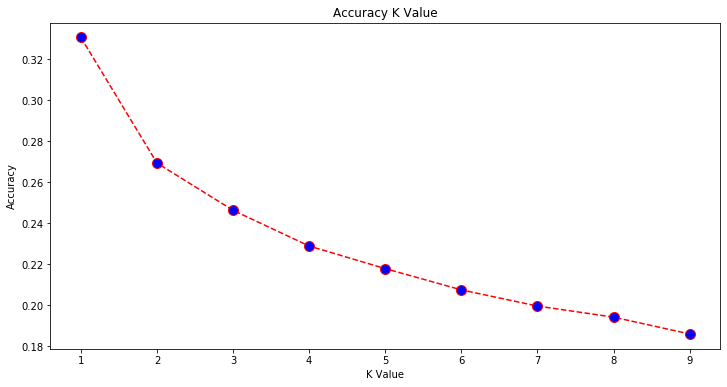

In [14]:
error = []
accuracy = []

# Calculating error for K values between 1 and 10
for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    #error.append(np.mean(pred_i != y_test))
    accuracy.append(metrics.accuracy_score(y_test, y_pred))

plt.figure(figsize = (12, 6))
plt.plot(range(1, 10), accuracy, color = 'red', linestyle = 'dashed', marker = 'o', markerfacecolor = 'blue', markersize = 10)
plt.title('Accuracy K Value')
plt.xlabel('K Value')
plt.ylabel('Accuracy')

In [15]:
from sklearn.model_selection import GridSearchCV

knn2 = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25)}
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
knn_gscv.fit(X_train, y_train)
print ('Best K value:', knn_gscv.best_params_)
print ('Best accuracy score', knn_gscv.best_score_)

Best K value: {'n_neighbors': 1}
Best accuracy score 0.3040446357412606


## is_booking ONLY equals 1

In [34]:
sel_train = sel_train[sel_train["is_booking"] == 1]
sel_train.reset_index()

y = sel_train["hotel_cluster"]
X = sel_train.drop("hotel_cluster", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

#### Decision Tree

In [35]:
depths = [2, 5, 10, 15, 17, 20, None]
criterion = ["gini", "entropy"]

for c in criterion:
    for d in depths:
        dtc = tree.DecisionTreeClassifier(criterion = c, max_depth = d).fit(X_train, y_train)
        y_pred_train = dtc.predict(X_train)
        y_pred_test = dtc.predict(X_test)
        
        print("Criterion: " + c)
        print("Depth: " + str(d))
        print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
        print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
        print()

Criterion: gini
Depth: 2
Train Accuracy: 0.08557310773377255
Test Accuracy: 0.07657758814282506

Criterion: gini
Depth: 5
Train Accuracy: 0.11544508497417084
Test Accuracy: 0.0958904109589041

Criterion: gini
Depth: 10
Train Accuracy: 0.20259040203638543
Test Accuracy: 0.11767347855378396

Criterion: gini
Depth: 15
Train Accuracy: 0.4185071498090889
Test Accuracy: 0.12194026498989445

Criterion: gini
Depth: 17
Train Accuracy: 0.5306580819046193
Test Accuracy: 0.12935099932629687

Criterion: gini
Depth: 20
Train Accuracy: 0.6879538818596991
Test Accuracy: 0.1408039523916461

Criterion: gini
Depth: None
Train Accuracy: 0.9995507973347308
Test Accuracy: 0.1504603637996856

Criterion: entropy
Depth: 2
Train Accuracy: 0.08886726061241297
Test Accuracy: 0.08084437457893555

Criterion: entropy
Depth: 5
Train Accuracy: 0.11439694542187617
Test Accuracy: 0.10577139007410734

Criterion: entropy
Depth: 10
Train Accuracy: 0.24736093434154377
Test Accuracy: 0.11071187963170896

Criterion: entropy
D

#### Random Forest

In [36]:
depths = [2, 5, 10, 15, 17, 20, None]

for d in depths:
    rf = RandomForestClassifier(max_depth = d).fit(X_train, y_train)
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)
    
    print("Depth: " + str(d))
    print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
    print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
    print()

Depth: 2
Train Accuracy: 0.08482443662499065
Test Accuracy: 0.0750056141926791

Depth: 5
Train Accuracy: 0.13169124803473833
Test Accuracy: 0.10666966090276218

Depth: 10
Train Accuracy: 0.3806243917047241
Test Accuracy: 0.14641814507073883

Depth: 15
Train Accuracy: 0.8068428539342667
Test Accuracy: 0.17695935324500336

Depth: 17
Train Accuracy: 0.9198173242494572
Test Accuracy: 0.18549292611722434

Depth: 20
Train Accuracy: 0.9889196675900277
Test Accuracy: 0.19133168650348079

Depth: None
Train Accuracy: 0.9995507973347308
Test Accuracy: 0.19874242083988322



#### KNN

Text(0, 0.5, 'Accuracy')

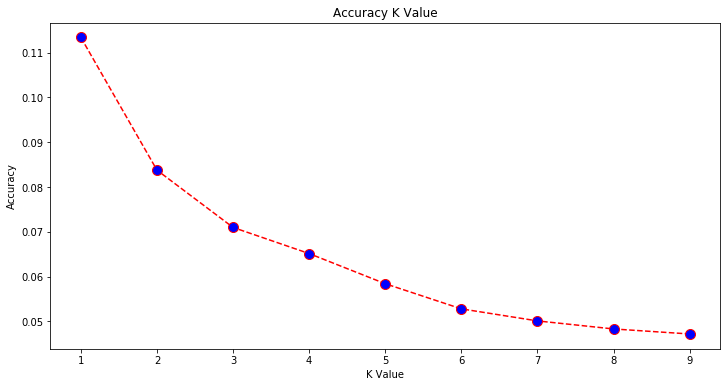

In [37]:
error = []
accuracy = []

# Calculating error for K values between 1 and 40
for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    #error.append(np.mean(pred_i != y_test))
    accuracy.append(metrics.accuracy_score(y_test, y_pred))

plt.figure(figsize = (12, 6))
plt.plot(range(1, 10), accuracy, color = 'red', linestyle = 'dashed', marker = 'o', markerfacecolor = 'blue', markersize = 10)
plt.title('Accuracy K Value')
plt.xlabel('K Value')
plt.ylabel('Accuracy')